In [1]:
# Import required libraries
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import train_test_split, cross_validate, PredefinedKFold
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import BaselineOnly, CoClustering
# import recmetrics as recmetrics ---> https://morioh.com/p/7208a4c1946d

import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

O conjunto de treino passa a consistir nas primeiras ~400 votações (existem 450 no total, mais ou menos), e um máximo de 10% das seguintes ~50. O teste serão os 90% de cada uma destas últimas votações

In [2]:
def evaluate_algorithms_binary(trainset, testset, algorithms):
    # Initialize dictionary to store results
    results = {}    
    for algorithm in algorithms:
        # train 
        algorithm.fit(trainset)
        
        # test
        predictions = algorithm.test(testset)

        # predicted ratings to 0 or 1 
        binary_predictions = [1 if p.est >= 0.5 else 0 for p in predictions]
        
        # binary_true_ratings is not needed - does not change anything
        binary_true_ratings = [1 if p.r_ui >= 0.5 else 0 for p in predictions]

        # Metrics
        acc = accuracy_score(binary_true_ratings, binary_predictions)
        precision, recall, f1_score, _ = precision_recall_fscore_support(binary_true_ratings, binary_predictions, average='binary')
        rmse = accuracy.rmse(predictions)
        mae = accuracy.mae(predictions)
        
        # Store results in dictionary
        results[algorithm.__class__.__name__] = {
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'test_rmse': rmse,
            'test_mae': mae,
        }

    # Convert dictionary to DataFrame and sort by F1 score
    results = pd.DataFrame.from_dict(results, orient='index')

    return results

In [15]:
def realistic_train_test(algorithms, dt, n=0.1):
    reader = Reader(rating_scale=(0, 1))
    dt = dt.sort_values(by='idVotacao')
    data = Dataset.load_from_df(dt[['deputado_enc', 'idVotacao', 'vote_enc']], reader)
    
    # first ~350
    train_indices = dt['idVotacao'].unique()[:350]
    # last ~50 votes
    test_indices = dt['idVotacao'].unique()[-50:]

    train_data = dt[dt['idVotacao'].isin(train_indices)]
    test_data = pd.DataFrame()

    for test_index in test_indices:
        test_votes = dt[dt['idVotacao'] == test_index]

        #10% of the votes for the train set
        size = int(len(test_votes) * n)
        
        #randomly select n rows from test_votes to into the train data
        train_votes = test_votes.sample(n=size, random_state=42)

        # add to train set
        train_data = pd.concat([train_data, train_votes])

        # remaining votes for the test set
        test_votes = test_votes[~test_votes.index.isin(train_votes.index)]
        test_data = pd.concat([test_data, test_votes])
        
    # remaining votes to train - it removes what was already used for test
    train_data = dt[~dt[['deputado_enc', 'idVotacao']].isin(test_data[['deputado_enc', 'idVotacao']]).all(axis=1)]

    trainset = Dataset.load_from_df(train_data[['deputado_enc', 'idVotacao', 'vote_enc']], reader).build_full_trainset()
    testset = Dataset.load_from_df(test_data[['deputado_enc', 'idVotacao', 'vote_enc']], reader).build_full_trainset().build_testset()

    ## use function to evaluate results
    results = evaluate_algorithms_binary(trainset,testset, algorithms)
    return results

In [4]:
def binary_knn_baseline(data, k=40, min_k=1, sim_options=None):
    """
    Builds and evaluates a KNNBaseline recommendation system
    """
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(dfP[['deputado_enc', 'idVotacao', 'vote_enc']], reader)
    trainset, testset = train_test_split(data, test_size=0.90)

    # Build the KNNBaseline recommendation system with the specified parameters
    if sim_options is None:
        sim_options = {'name': 'pearson_baseline', 'user_based': False}
        
    algo = KNNBaseline(k=k, min_k=min_k, sim_options=sim_options)
    r = evaluate_algorithms_binary(trainset, testset, algo)
    return r

In [5]:
# Load the data into a pandas dataframe
dfP = pd.read_csv('..\data\preprocessed\dataVoting.csv')
dfP

,Unnamed: 0,idVotacao,siglaOrgao,idEvento,aprovacao,uriVotacao,voto,deputado_id,deputado_nome,deputado_siglaPartido,...,idLegislaturaFinal,siglaSexo,municipioNascimento,idade,new,score_accordingly,deputado_enc,orientacao_enc,gender_enc,vote_enc
0,0,2312874-9,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,4
1,1,46249-294,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,2
2,2,46249-297,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,3,1,4
3,3,46249-312,PLEN,64653,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,4
4,4,46249-316,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112151,112151,2323617-49,PLEN,66394,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,0,68.00,317,0,1,4
112152,112152,2323617-56,PLEN,66394,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,1,1,2
112153,112153,2314962-33,PLEN,66455,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,3,1,4
112154,112154,2326278-38,PLEN,66439,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,205535,Patricia Ferraz,PODE,...,56,F,Belo Horizonte,43.0,1,40.76,277,1,0,2


In [6]:
df_bool = dfP.loc[(dfP["vote_enc"] == 2) | (dfP["vote_enc"] == 4)] 
## replace values for 2 and 4 to 0 and 1
df_bool["vote_enc"].replace({2: 0, 4: 1}, inplace=True)
df_bool

c:\Users\ritac\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Unnamed: 0,idVotacao,siglaOrgao,idEvento,aprovacao,uriVotacao,voto,deputado_id,deputado_nome,deputado_siglaPartido,...,idLegislaturaFinal,siglaSexo,municipioNascimento,idade,new,score_accordingly,deputado_enc,orientacao_enc,gender_enc,vote_enc
0,0,2312874-9,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,1
1,1,46249-294,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,0
2,2,46249-297,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,3,1,1
3,3,46249-312,PLEN,64653,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,1
4,4,46249-316,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112151,112151,2323617-49,PLEN,66394,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,0,68.00,317,0,1,1
112152,112152,2323617-56,PLEN,66394,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,1,1,0
112153,112153,2314962-33,PLEN,66455,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,3,1,1
112154,112154,2326278-38,PLEN,66439,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,205535,Patricia Ferraz,PODE,...,56,F,Belo Horizonte,43.0,1,40.76,277,1,0,0


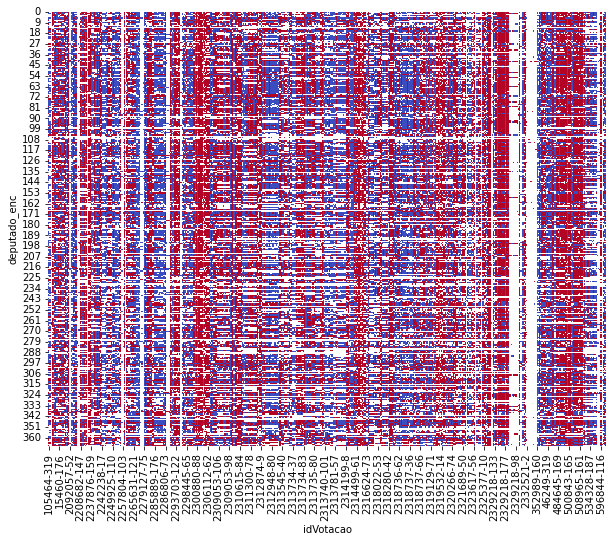

In [7]:
# Create a pivot table with NC as rows, A as columns, and rating as values
pivot_table = df_bool.pivot_table(index='deputado_enc', columns='idVotacao', values='vote_enc')
    
# Create a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(pivot_table, cmap='coolwarm', cbar=False)
plt.show()

In [8]:
df_bool['idVotacao'].value_counts()

2329218-153    334
508965-164     332
2329218-162    331
2329218-192    330
2329218-165    329
              ... 
2334095-31       3
2334096-29       2
2334095-19       2
2334096-11       1
2334095-11       1
Name: idVotacao, Length: 473, dtype: int64

In [9]:
# count the number of times each voting id appears in the dataset
counts = df_bool.groupby("idVotacao").size()
mask = counts > 200
voting_ids = counts[mask].index.tolist()

mask = df_bool["idVotacao"].isin(voting_ids)

df_filtered = df_bool[mask]
df_filtered

,Unnamed: 0,idVotacao,siglaOrgao,idEvento,aprovacao,uriVotacao,voto,deputado_id,deputado_nome,deputado_siglaPartido,...,idLegislaturaFinal,siglaSexo,municipioNascimento,idade,new,score_accordingly,deputado_enc,orientacao_enc,gender_enc,vote_enc
0,0,2312874-9,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,1
1,1,46249-294,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,0
2,2,46249-297,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,3,1,1
3,3,46249-312,PLEN,64653,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,1
4,4,46249-316,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112150,112150,2324900-55,PLEN,66394,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,3,1,1
112152,112152,2323617-56,PLEN,66394,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,1,1,0
112153,112153,2314962-33,PLEN,66455,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,3,1,1
112154,112154,2326278-38,PLEN,66439,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,205535,Patricia Ferraz,PODE,...,56,F,Belo Horizonte,43.0,1,40.76,277,1,0,0


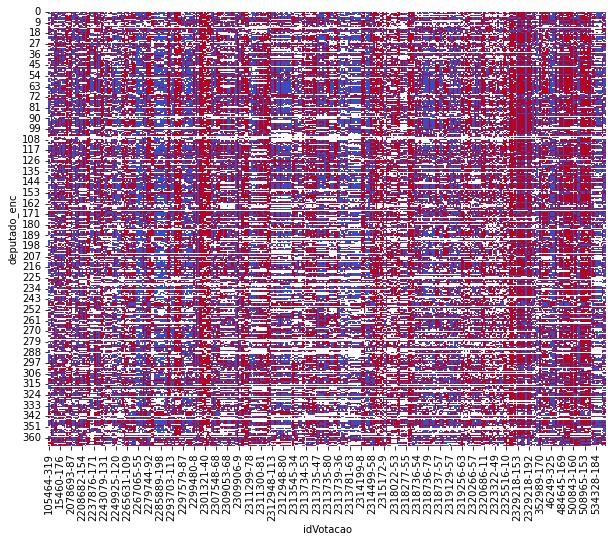

In [10]:
# Create a pivot table with NC as rows, A as columns, and rating as values
pivot_table = df_filtered.pivot_table(index='deputado_enc', columns='idVotacao', values='vote_enc')

# Create a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(pivot_table, cmap='coolwarm', cbar=False)
plt.show()

In [11]:
df_filtered['idVotacao'].value_counts()

2329218-153    334
508965-164     332
2329218-162    331
2329218-192    330
2329218-165    329
              ... 
2313781-70     205
2283448-53     205
2324900-47     203
2243079-167    202
2316624-73     201
Name: idVotacao, Length: 400, dtype: int64

In [12]:
df_filtered.groupby(['deputado_enc', 'idVotacao']).tail(1)

,Unnamed: 0,idVotacao,siglaOrgao,idEvento,aprovacao,uriVotacao,voto,deputado_id,deputado_nome,deputado_siglaPartido,...,idLegislaturaFinal,siglaSexo,municipioNascimento,idade,new,score_accordingly,deputado_enc,orientacao_enc,gender_enc,vote_enc
0,0,2312874-9,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,1
1,1,46249-294,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,0
2,2,46249-297,PLEN,64653,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,3,1,1
3,3,46249-312,PLEN,64653,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,0,72.56,2,1,1,1
4,4,46249-316,PLEN,64653,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,204554,Abílio Santana,PL,...,56,M,Salvador,58.0,1,72.56,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112150,112150,2324900-55,PLEN,66394,2.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,3,1,1
112152,112152,2323617-56,PLEN,66394,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,1,1,0
112153,112153,2314962-33,PLEN,66455,1.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Sim,122466,Ronaldo Martins,REPUBLICANOS,...,56,M,São Paulo,45.0,1,68.00,317,3,1,1
112154,112154,2326278-38,PLEN,66439,0.0,https://dadosabertos.camara.leg.br/api/v2/vota...,Não,205535,Patricia Ferraz,PODE,...,56,F,Belo Horizonte,43.0,1,40.76,277,1,0,0


In [16]:
##OLD FUNCTION ~ WITOUHOUT JOINED 10% OF TEST
algorithms = [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering()]
results1 = realistic_train_test(algorithms, df_filtered)
results1

RMSE: 0.3041
MAE:  0.2360
RMSE: 0.3913
MAE:  0.3015
RMSE: 0.2445
MAE:  0.1718
RMSE: 0.6106
MAE:  0.4936
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3630
MAE:  0.2650
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3645
MAE:  0.2668
Estimating biases using als...
RMSE: 0.3988
MAE:  0.3485
RMSE: 0.2353
MAE:  0.1195


,accuracy,precision,recall,f1_score,test_rmse,test_mae
SVD,0.897317,0.894580,0.932928,0.913351,0.304094,0.236016
SlopeOne,0.814951,0.813652,0.883300,0.847047,0.391286,0.301454
NMF,0.942579,0.951729,0.949155,0.950440,0.244492,0.171819
NormalPredictor,0.505020,0.574817,0.563624,0.569166,0.610612,0.493593
KNNBaseline,0.815736,0.814197,0.884111,0.847715,0.362986,0.265030
KNNWithMeans,0.815736,0.814119,0.884246,0.847734,0.364532,0.266801
BaselineOnly,0.814873,0.813551,0.883300,0.846992,0.398790,0.348534
CoClustering,0.940775,0.944088,0.954429,0.949230,0.235346,0.119523


In [17]:
## 10% de teste no train
algorithms = [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering()]
results2 = realistic_train_test(algorithms, df_filtered)
results2

RMSE: 0.3086
MAE:  0.2412
RMSE: 0.3913
MAE:  0.3015
RMSE: 0.2433
MAE:  0.1715
RMSE: 0.6092
MAE:  0.4936
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3630
MAE:  0.2650
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3645
MAE:  0.2668
Estimating biases using als...
RMSE: 0.3988
MAE:  0.3485
RMSE: 0.2356
MAE:  0.1209


,accuracy,precision,recall,f1_score,test_rmse,test_mae
SVD,0.889081,0.887521,0.926166,0.906432,0.308602,0.241219
SlopeOne,0.814951,0.813652,0.883300,0.847047,0.391286,0.301454
NMF,0.942344,0.951954,0.948479,0.950213,0.243264,0.171524
NormalPredictor,0.507844,0.579223,0.554158,0.566413,0.609203,0.493559
KNNBaseline,0.815736,0.814197,0.884111,0.847715,0.362986,0.265030
KNNWithMeans,0.815736,0.814119,0.884246,0.847734,0.364532,0.266801
BaselineOnly,0.814873,0.813551,0.883300,0.846992,0.398790,0.348534
CoClustering,0.940775,0.944088,0.954429,0.949230,0.235633,0.120903


In [18]:
# 5% de teste em treino
algorithms = [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering()]
results3 = realistic_train_test(algorithms, df_filtered, n=0.05)
results3

RMSE: 0.3717
MAE:  0.3228
RMSE: 0.4004
MAE:  0.3073
RMSE: 0.2515
MAE:  0.1747
RMSE: 0.6085
MAE:  0.4896
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3717
MAE:  0.2710
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3733
MAE:  0.2726
Estimating biases using als...
RMSE: 0.4158
MAE:  0.3830
RMSE: 0.2571
MAE:  0.1393


,accuracy,precision,recall,f1_score,test_rmse,test_mae
SVD,0.846440,0.841060,0.906586,0.872595,0.371682,0.322796
SlopeOne,0.808161,0.809603,0.875064,0.841062,0.400449,0.307324
NMF,0.936376,0.951286,0.938365,0.944781,0.251468,0.174653
NormalPredictor,0.510926,0.581950,0.556894,0.569146,0.608489,0.489598
KNNBaseline,0.821020,0.817113,0.890825,0.852379,0.371739,0.271013
KNNWithMeans,0.820871,0.816549,0.891466,0.852365,0.373331,0.272635
BaselineOnly,0.806898,0.798372,0.892491,0.842812,0.415815,0.382978
CoClustering,0.931768,0.936154,0.946950,0.941521,0.257082,0.139272


In [19]:
# 1% de teste em treino
algorithms = [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering()]
results4 = realistic_train_test(algorithms, df_filtered, n = 0.01)
results4

RMSE: 0.4545
MAE:  0.4366
RMSE: 0.4720
MAE:  0.3132
RMSE: 0.3290
MAE:  0.2098
RMSE: 0.6047
MAE:  0.4874
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4454
MAE:  0.2885
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4435
MAE:  0.2894
Estimating biases using als...
RMSE: 0.4671
MAE:  0.4558
RMSE: 0.4178
MAE:  0.2396


,accuracy,precision,recall,f1_score,test_rmse,test_mae
SVD,0.724802,0.704278,0.905500,0.792313,0.454487,0.436586
SlopeOne,0.721093,0.728613,0.826873,0.774640,0.472043,0.313151
NMF,0.883943,0.931034,0.863787,0.896151,0.328955,0.209785
NormalPredictor,0.515301,0.584155,0.568845,0.576398,0.604732,0.487414
KNNBaseline,0.758328,0.765252,0.841147,0.801407,0.445429,0.288502
KNNWithMeans,0.755617,0.765563,0.833764,0.798209,0.443470,0.289377
BaselineOnly,0.723518,0.697776,0.922727,0.794638,0.467054,0.455767
CoClustering,0.816891,0.814764,0.885444,0.848635,0.417806,0.239567


In [20]:
# 2% de teste em treino
algorithms = [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNWithMeans(), BaselineOnly(), CoClustering()]
results5 = realistic_train_test(algorithms, df_filtered, n = 0.02)
results5

RMSE: 0.4252
MAE:  0.3979
RMSE: 0.4139
MAE:  0.2971
RMSE: 0.2795
MAE:  0.1852
RMSE: 0.6156
MAE:  0.4991
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3877
MAE:  0.2690
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3888
MAE:  0.2702
Estimating biases using als...
RMSE: 0.4418
MAE:  0.4249
RMSE: 0.3039
MAE:  0.1616


,accuracy,precision,recall,f1_score,test_rmse,test_mae
SVD,0.793342,0.778160,0.900360,0.834812,0.425224,0.397892
SlopeOne,0.797521,0.812105,0.846813,0.829096,0.413936,0.297060
NMF,0.920450,0.951150,0.909554,0.929887,0.279476,0.185201
NormalPredictor,0.500432,0.572093,0.550130,0.560897,0.615578,0.499056
KNNBaseline,0.813662,0.825916,0.859983,0.842605,0.387710,0.268961
KNNWithMeans,0.813374,0.826066,0.859113,0.842266,0.388761,0.270161
BaselineOnly,0.774391,0.763220,0.885824,0.819964,0.441820,0.424934
CoClustering,0.906182,0.915098,0.923966,0.919510,0.303866,0.161610


In [21]:
##n_factors: 100, n_epochs:20, biased:True, lr_all: 0.005, reg_all:0.02
svd_params = {'n_factors': 350, 'n_epochs': 60, 'biased': True, 'lr_all': 0.005, 'reg_all': 0.02}

algorithms = [SVD(**svd_params)]
results1 = realistic_train_test(algorithms, df_filtered)
results1

RMSE: 0.2606
MAE:  0.1860


,accuracy,precision,recall,f1_score,test_rmse,test_mae
SVD,0.926341,0.929598,0.944557,0.937018,0.260596,0.186031
